In [1]:
from gc import is_finalized
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.10.0+cpu


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)
#Copy the dataset to this folder
project_root = os.getcwd()  # current working directory
target_dir = os.path.join(project_root, "COVID-19 Radiography Database")

# Copy only once
if not os.path.exists(target_dir):
    shutil.copytree(path, target_dir)

print("Dataset copied to:", target_dir)


In [8]:
import os
import random
import shutil

class_names = ['normal', 'viral', 'COVID']
root_dir = 'COVID-19_Radiography_Dataset'
test_size = 30  # images per class

# Create test directory
test_root = os.path.join(root_dir, 'test')
os.makedirs(test_root, exist_ok=True)

for cls in class_names:
    source_img_dir = os.path.join(root_dir, cls, 'images')
    test_cls_dir = os.path.join(test_root, cls)

    os.makedirs(test_cls_dir, exist_ok=True)

    images = [
        img for img in os.listdir(source_img_dir)
        if img.lower().endswith('.png')
    ]

    selected_images = random.sample(images, test_size)

    for img in selected_images:
        src = os.path.join(source_img_dir, img)
        dst = os.path.join(test_cls_dir, img)
        shutil.move(src, dst)

    print(f"Moved {test_size} images to test/{cls}")


Moved 30 images to test/COVID


Creating Custom Dataset for PyTorch

In [2]:
class ChestXRayDataset(torch.utils.data.Dataset):
    #image_dirs is a dictionary which has path of 3 classes
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images= [ x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f"Found {len(images)} {class_name} examples")
            return images
        #self.images is a dictionary with class as the key and a list of images as the values that will be
        #found by the get_images function
        self.images={}
        self.class_names= ["normal", "viral", "covid"]

        for c in self.class_names:
            self.images[c]= get_images(c)

        self.image_dirs= image_dirs
        self.transform = transform

    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    #we must implement the getitem function
    #for a given index, it needs to return the corresponding example
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        #since different classes have different lengths, so we modulo by its length for the index
        #so bigger length means a bigger index
        index= index % len(self.images[class_name])
        image_name= self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image= Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)



Image Transformations

In [3]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean= [0.485,0.456,0.406], std= [0.229,0.224,0.225])
])

In [4]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean= [0.485,0.456,0.406], std= [0.229,0.224,0.225])
])

Preparing DataLoader

In [5]:
train_dirs= {
    'normal': 'COVID-19_Radiography_Dataset/normal/images',
    'viral': 'COVID-19_Radiography_Dataset/viral/images',
    'covid':'COVID-19_Radiography_Dataset/COVID/images'
}
train_dataset= ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [6]:
test_dirs= {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral': 'COVID-19_Radiography_Dataset/test/viral',
    'covid':'COVID-19_Radiography_Dataset/test/COVID'
}
test_dataset= ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [7]:
batch_size=6
dl_train= torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dl_test= torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=True)

In [8]:
print("Number of training batches", len(dl_train))
print("Number of test batches", len(dl_test))

Number of training batches 2511
Number of test batches 15


Data Visualization

In [9]:
class_names= train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i,image in enumerate(images):
        plt.subplot(1,6, i+1, xticks=[], yticks=[])
        image= image.numpy().transpose((1,2,0))
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        col = 'green' if preds[i]==labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

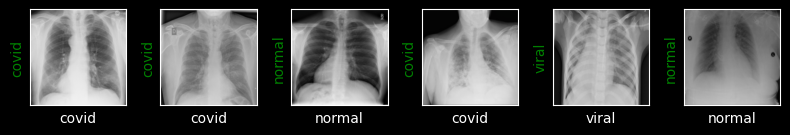

In [10]:
images,labels = next(iter(dl_train))
show_images(images,labels,labels)

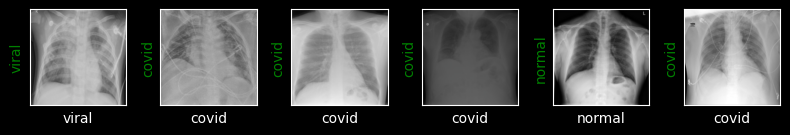

In [11]:
images, labels= next(iter(dl_test))
show_images(images,labels,labels)

Creating the Model

Loads ResNet-18, a convolutional neural network
pretrained=True means:
The model is already trained on ImageNet (1.2M images, 1000 classes)
It already knows how to detect:
edges
textures
shapes
patterns

In [12]:
resnet18= torchvision.models.resnet18(pretrained=True)
print(resnet18)

C:\Users\GC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\GC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Replace the final classification layer

In [13]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn= torch.nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(resnet18.parameters(), lr=3e-5)


In [14]:
def show_preds():
    resnet18.eval()
    images, labels= next(iter(dl_test))
    outputs= resnet18(images)
    _,preds = torch.max(outputs, 1)
    show_images(images,labels,preds)

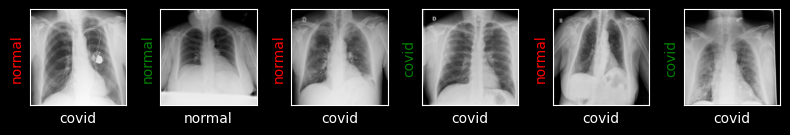

In [15]:
show_preds()

Training the Model

In [17]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 5 == 0:
                print('Evaluating at step', train_step)

                acc = 0.0
                val_loss = 0.0
                resnet18.eval()

                with torch.no_grad():
                    for val_step, (images, labels) in enumerate(dl_test):
                        outputs = resnet18(images)
                        loss = loss_fn(outputs, labels)
                        val_loss += loss.item()

                        _, preds = torch.max(outputs, 1)
                        acc += (preds == labels).sum().item()

                val_loss /= (val_step + 1)
                acc /= len(test_dataset)

                print(f'Val Loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                resnet18.train()


                if acc >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [18]:
%%time

train(epochs=1)

Performance condition satisfied, stopping..
CPU times: total: 14min 12s
Wall time: 3min 42s


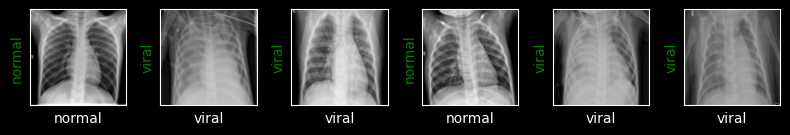

In [40]:
show_preds()